<h1 id="title">Sampling at 0.25 x Minority Class Size, Testing on All the Data, Predicting Motor Vehicle Accident Severity in Seattle, Washington<\h1>

In [1]:
# Import packages and modules.
import io
import itertools
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import pylab as pl
import scipy
import scipy.optimize as opt
import seaborn as sns
import sklearn
import sys
import timeit
import warnings
from matplotlib.ticker import NullFormatter
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.sparse import csr_matrix
from sklearn import linear_model
from sklearn import metrics
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree
from sklearn import utils
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.exceptions import ConvergenceWarning
from timeit import default_timer
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")

In [3]:
# Define the starting time for this notebook. 
notebook_start_time = default_timer()

In [4]:
# This function computes the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def elapsed_time(start_time = notebook_start_time):
    return default_timer() - start_time   

In [5]:
# This function prints the time elapsed in seconds from the 
# time represented by the first parameter (start_time)
# to the time represented by the second parameter (end_time)
# This function requires the os package to be imported.
def print_elapsed_time(start_time = notebook_start_time):
    print("Elapsed time is", elapsed_time(start_time), "seconds.")
    return None

In [6]:
# Create a list of display options.
list_of_display_options_fully_qualified_names = str(\
"pd.options.display.chop_threshold, pd.options.display.float_format, pd.options.display.max_info_columns, pd.options.display.notebook_repr_html, \
pd.options.display.colheader_justify, pd.options.display.html, pd.options.display.max_info_rows, pd.options.display.pprint_nest_depth, \
pd.options.display.column_space, pd.options.display.large_repr, pd.options.display.max_rows, pd.options.display.precision, \
pd.options.display.date_dayfirst, pd.options.display.latex, pd.options.display.max_seq_items, pd.options.display.show_dimensions, \
pd.options.display.date_yearfirst, pd.options.display.max_categories, pd.options.display.memory_usage, pd.options.display.unicode, \
pd.options.display.encoding, pd.options.display.max_columns, pd.options.display.min_rows, pd.options.display.width, \
pd.options.display.expand_frame_repr, pd.options.display.max_colwidth, pd.options.display.multi_sparse").split(sep=', ')

# Initialize an empty list to store all the short names for display options.
list_of_display_options_short_names = list()
# For each fully qualified option name,
# get the option's short name and add it to the list of short names.
for fully_qualified_option_name in list_of_display_options_fully_qualified_names:
    # Get short option name.
    short_option_name = fully_qualified_option_name.split(sep='.')[-1]
    
    # Add short option name to list of display option short names.
    list_of_display_options_short_names.append(short_option_name)

# Define dictionary of display option settings.
dict_of_display_option_settings_short_names=\
{"max_info_columns": 1000,\
"colheader_justify": "right",\
"max_info_rows": 1000000,\
"column_space": 1000,\
"max_rows": 1000000,\
"precision": 9,\
"max_seq_items": 1000000000000,\
"show_dimensions": True,\
"max_categories": 100,\
"memory_usage": True,\
"max_columns": 1000,\
"max_colwidth": 1000,\
"float_format": lambda x: '%.9f' % x}

# Set pandas display options using dictionary of short names,
# and display the options/value pairs.
print("Setting display options...")
for key in list(dict_of_display_option_settings_short_names.keys()):
    # Set display option.
    pd.set_option(key, dict_of_display_option_settings_short_names[key])
    # Print display option name and value.
    print(key, ": ", pd.get_option(key), sep='')

Setting display options...
max_info_columns: 1000
colheader_justify: right
max_info_rows: 1000000
column_space: 1000
max_rows: 1000000
precision: 9
max_seq_items: 1000000000000
show_dimensions: True
max_categories: 100
memory_usage: True
max_columns: 1000
max_colwidth: 1000
float_format: <function <lambda> at 0x7f38e3638040>


In [7]:
# Set seed for random number generator.
# seed = np.int(os.times()[4]) # Use this line for better pseudo-random behavior.
seed = 42
print(seed)

42


In [8]:
# Attribute Information URL: https://www.seattle.gov/Documents/Departments/SDOT/GIS/Collisions_OD.pdf
# Read the Collisions Data CSV file and store it as a DataFrame.
# url="https://opendata.arcgis.com/datasets/5b5c745e0f1f48e7a53acec63a0022ab_0.csv" # HTTPError at 202009151050, using local copy of .csv instead.
# print(os.listdir("..")) # Print list of contents of current working directory.
local_path_to_csv = '~/IBM Data Science Professional Certificate Course/Course 9 - Applied Data Science Capstone/projects/Collisions.csv'
df=pd.read_csv(local_path_to_csv, low_memory=False)

In [9]:
# View the first few rows of the collisions DataFrame.
df.head()

,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,-122.320757054,47.609407946,1,328476,329976,EA08706,Matched,Block,nan,BROADWAY BETWEEN E COLUMBIA ST AND BOYLSTON AVE,,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,0,0,0,2020/01/22 00:00:00+00,1/22/2020 3:21:00 PM,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,N,Raining,Wet,Dark - Street Lights On,NaN,nan,NaN,11,From same direction - both going straight - both moving - sideswipe,0,0,N
1,-122.319560827,47.662220664,2,328142,329642,EA06882,Matched,Block,nan,8TH AVE NE BETWEEN NE 45TH E ST AND NE 47TH ST,,NaN,1,Property Damage Only Collision,Parked Car,2,0,0,2,0,0,0,2020/01/07 00:00:00+00,1/7/2020 8:00:00 AM,Mid-Block (not related to intersection),15.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, RIGHT SIDE SIDESWIPE",NaN,N,Clear,Dry,Daylight,NaN,nan,NaN,32,One parked--one moving,0,0,Y
2,-122.327524508,47.604393273,3,20700,20700,1181833,Unmatched,Block,nan,JAMES ST BETWEEN 6TH AVE AND 7TH AVE,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/30 00:00:00+00,1/30/2004,Mid-Block (but intersection related),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4030032.000000000,NaN,NaN,NaN,0,0,N
3,-122.327524934,47.708621579,4,332126,333626,M16001640,Unmatched,Block,nan,NE NORTHGATE WAY BETWEEN 1ST AVE NE AND NE NORTHGATE DR,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2016/01/23 00:00:00+00,1/23/2016,Mid-Block (not related to intersection),11.000000000,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N
4,-122.292120049,47.559009080,5,328238,329738,3857118,Unmatched,Block,nan,M L KING JR ER WAY S BETWEEN S ANGELINE ST AND S EDMUNDS ST,,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2020/01/26 00:00:00+00,1/26/2020,Mid-Block (not related to intersection),28.000000000,MOTOR VEHICLE RAN OFF ROAD - HIT FIXED OBJECT,NaN,NaN,NaN,NaN,NaN,NaN,nan,NaN,,NaN,0,0,N


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221389 entries, 0 to 221388
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   X                213918 non-null  float64
 1   Y                213918 non-null  float64
 2   OBJECTID         221389 non-null  int64  
 3   INCKEY           221389 non-null  int64  
 4   COLDETKEY        221389 non-null  int64  
 5   REPORTNO         221389 non-null  object 
 6   STATUS           221389 non-null  object 
 7   ADDRTYPE         217677 non-null  object 
 8   INTKEY           71884 non-null   float64
 9   LOCATION         216801 non-null  object 
 10  EXCEPTRSNCODE    100986 non-null  object 
 11  EXCEPTRSNDESC    11779 non-null   object 
 12  SEVERITYCODE     221388 non-null  object 
 13  SEVERITYDESC     221389 non-null  object 
 14  COLLISIONTYPE    195159 non-null  object 
 15  PERSONCOUNT      221389 non-null  int64  
 16  PEDCOUNT         221389 non-null  int6

In [11]:
print_elapsed_time(notebook_start_time)

Elapsed time is 9.130927875987254 seconds.


<h2 id="data_wrangling">Data Wrangling</h2>

Steps for working with missing data:
<ol>
    <li>Identify missing data.</li>
    <li>Deal with missing data.</li>
    <li>Correct data format.</li>
</ol>

<h3 id="identifying_missing_data">Identifying Missing Data</h3>

The metadata document that accompanied the data set indicates that certain columns have "sentinel" values
that indicate an unknown or missing value. Each of these missing values will first be converted into NaN.
Subsequently, the NaN values will be dropped from the DataFrame.

In [12]:
# If any row of the collisions DataFrame contains a sentinel value representing "unknown",
# then replace it with NaN. 
# Sentinels for "unknown" are listed in the metadata document that accompanies the dataset.
df_unknowns_converted_to_nan = df.replace(to_replace=\
{"EXCEPTRSNCODE": " ",\
 "EXCEPTRSNDESC": "Not Enough Information, or Insufficient Location Information",\
 "SEVERITYCODE": "0",\
 "SEVERITYDESC": "Unknown",\
 "JUNCTIONTYPE": "Unknown",\
 "WEATHER": "Unknown",\
 "ROADCOND": "Unknown",\
 "LIGHTCOND": "Unknown",\
 "SDOT_COLCODE": float(0),\
 "SDOT_COLDESC": "NOT ENOUGH INFORMATION / NOT APPLICABLE",\
 "ST_COLCODE": " ",\
 "ST_COLDESC": "Not stated"},\
value=np.nan, inplace=False, limit=None, regex=False, method='pad')

df_unknowns_converted_to_nan.replace(to_replace={"ST_COLCODE": "0", }, value=np.nan, inplace=True, limit=None, regex=False, method='pad')

In [13]:
print_elapsed_time(notebook_start_time)

Elapsed time is 15.854447018005885 seconds.


<h3 id="deal_with_missing_data">Deal with Missing Data</h3>

<ol>
    <li>Drop the Data
        <ol>
            <li>Drop entire row.</li>
            <li>Drop entire column.</li>
        </ol>
    </li>
    <li>Replace the Data
        <ol>
            <li>Replace data by mean.</li>
            <li>Replace data by frequency.</li>
            <li>Replace data based on other functions.</li>
        </ol>
    </li>
        
</ol>

Whole columns should be dropped only if most entries in the column are empty.

In [14]:
print(list(df.columns))

['X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR']


In [15]:
# Drop any column from the collisions DataFrame if it satisfies at least one of the following conditions:
# 1) more than 15% of the column's data is NaN;
# 2) the column only contains unique identification keys, or information not useful for model building;
# 3) the column's data is categorical but does not fit into a small (< 15) number of categories;
# 4) information in the column is redundant because it is already represented by another column;
# 5) it is not clear how to interpret the column's data.
list_of_columns_to_drop = ["ADDRTYPE",\
                           "STATUS",\
                           "OBJECTID",\
                           "INCKEY",\
                           "COLDETKEY",\
                           "REPORTNO",\
                           "INTKEY",\
                           "LOCATION",\
                           "EXCEPTRSNCODE",\
                           "EXCEPTRSNDESC",\
                           "SEVERITYDESC",\
                           "INCDATE",\
                           "INCDTTM",\
                           "JUNCTIONTYPE",\
                           "SDOT_COLCODE",\
                           "SDOT_COLDESC",\
                           "INATTENTIONIND",\
                           "UNDERINFL",\
                           "PEDROWNOTGRNT",\
                           "SDOTCOLNUM",\
                           "SPEEDING",\
                           "ST_COLCODE",\
                           "ST_COLDESC",\
                           "SEGLANEKEY",\
                           "CROSSWALKKEY",\
                           "HITPARKEDCAR"]

In [16]:
# Drop the selected columns from the DataFrame after converting unknowns to NaN.
# Store the result in a new DataFrame.
df_drop_columns = df_unknowns_converted_to_nan.drop(columns=list_of_columns_to_drop, inplace=False)

In [17]:
# Drop any row that contains at least one NaN.
df_drop_columns_and_rows = df_drop_columns.dropna(axis="index", how="any", thresh=None, subset=None, inplace=False)

In [18]:
print_elapsed_time(notebook_start_time)

Elapsed time is 16.839723001932725 seconds.


<h3 id="correct_data_format">Correct Data Format</h3>

Ensure that each data type is appropriate for the corresponding feature.
Cast columns of type "object" as type "category", but leave all other column types unaltered.

In [19]:
# Create new DataFrame to store converted data types.
df_converted = pd.DataFrame()

for column in list(df_drop_columns_and_rows.columns):
    if (df_drop_columns_and_rows[column].dtype in [np.dtype('object')]):
        df_converted[column] = df_drop_columns_and_rows[column].astype('category')
    # Copy all other columns to new DataFrame without changing their types.
    else:
        df_converted[column] = df_drop_columns_and_rows[column]

In [20]:
# Create DataFrame of categorical or integer columns, inclusive.
df_categorical = df_converted.select_dtypes(include=["category", "integer"])

In [21]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.500363976927474 seconds.


<h2 id="feature_selection">Feature selection</h2>

#### Features before One-Hot Encoding

In [22]:
df_categorical.head()

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,WEATHER,ROADCOND,LIGHTCOND
0,1,Sideswipe,2,0,0,2,0,0,0,Raining,Wet,Dark - Street Lights On
1,1,Parked Car,2,0,0,2,0,0,0,Clear,Dry,Daylight
5,1,Rear Ended,2,0,0,2,0,0,0,Clear,Dry,Daylight
6,1,Other,2,0,0,1,0,0,0,Clear,Wet,Daylight
8,1,Sideswipe,2,0,0,2,0,0,0,Overcast,Dry,Daylight


In [23]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [24]:
print_elapsed_time(notebook_start_time)

Elapsed time is 17.878859361982904 seconds.


<h2 id="imbalanced_data">Dealing with Imbalanced Data</h2>

Because the data is imbalanced, we split the DataFrame into four DataFrames, one for each value of the SEVERITYCODE feature.

In [25]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
1    0.657943120
2    0.323036911
2b   0.017111571
3    0.001908397
Name: SEVERITYCODE, Length: 4, dtype: float64


In [26]:
print("SEVERITYCODE relative frequencies:")
print(df_categorical["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
2      55521
2b      2941
3        328
Name: SEVERITYCODE, Length: 4, dtype: int64


In [27]:
df_class_1 = df_categorical[df_categorical['SEVERITYCODE'] == '1']
df_class_2 = df_categorical[df_categorical['SEVERITYCODE'] == '2']
df_class_2b = df_categorical[df_categorical['SEVERITYCODE'] == '2b']
df_class_3 = df_categorical[df_categorical['SEVERITYCODE'] == '3']

In [28]:
print("SEVERITYCODE relative frequencies:")
print(df_class_1["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
1     113082
3          0
2b         0
2          0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [29]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2     55521
3         0
2b        0
1         0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [30]:
print("SEVERITYCODE relative frequencies:")
print(df_class_2b["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
2b    2941
3        0
2        0
1        0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [31]:
print("SEVERITYCODE relative frequencies:")
print(df_class_3["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     328
2b      0
2       0
1       0
Name: SEVERITYCODE, Length: 4, dtype: int64


In [32]:
# Store and print the size of the all classes.
class_1_size = len(df_class_1)
class_2_size = len(df_class_2)
class_2b_size = len(df_class_2b)
class_3_size = len(df_class_3)
print('class 1 size =', class_1_size)
print('class 2 size =', class_2_size)
print('class 2b size =', class_2b_size)
print('class 3 size =', class_3_size)
print()
# Store and print the size of the minority class.
minority_class_size = len(df_class_3)
print('minority class size =', minority_class_size)

class 1 size = 113082
class 2 size = 55521
class 2b size = 2941
class 3 size = 328

minority class size = 328


In [33]:
print_elapsed_time(notebook_start_time)

Elapsed time is 19.02036095201038 seconds.


<h2 id='sample_size_class_3'>Balance the Dataset by Sampling all Classes Equally<\h2>

In [34]:
# This sampling parameter provides conventient control for the oversampling of the minority classes
# and, consequently, for the undersampling of the majority classes.
sampling_parameter = 0.25 * class_3_size

In [35]:
# Set the size of sample to take from each class of accident severity.
# To balance the dataset, ensure that all samples are of the same size.
sample_size_class_1 = np.int(sampling_parameter)
sample_size_class_2 = np.int(sampling_parameter)
sample_size_class_2b = np.int(sampling_parameter)
sample_size_class_3 = np.int(sampling_parameter)

In [36]:
# Sample all classes equally, with the number of samples equal to the size of class '3'.
# Replacement flag is boolean with value set as follows:
# If class_size > sample_size, then parameter replace is passed the value True.
# Otherwise, parameter replace is passed the value False.
replaceFlag = bool(class_1_size < sample_size_class_1)
print('bool(class_1_size < sample_size_class_1) = %s' % bool(class_1_size < sample_size_class_1))
df_class_1_sampled = df_class_1.sample(n=sample_size_class_1,replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2_size < sample_size_class_2)
print('bool(class_2_size < sample_size_class_2) = %s' % bool(class_2_size < sample_size_class_2))
df_class_2_sampled = df_class_2.sample(n=sample_size_class_2, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_2b_size < sample_size_class_2b)
print('bool(class_2b_size < sample_size_class_2b) = %s' % bool(class_2b_size < sample_size_class_2b))
df_class_2b_sampled = df_class_2b.sample(n=sample_size_class_2b, replace=replaceFlag, axis='index', random_state=seed)

replaceFlag = bool(class_3_size < sample_size_class_3)
print('bool(class_3_size < sample_size_class_3) = %s' % bool(class_3_size < sample_size_class_3))
df_class_3_sampled = df_class_3.sample(n=sample_size_class_3, replace=replaceFlag, axis='index', random_state=seed)

bool(class_1_size < sample_size_class_1) = False
bool(class_2_size < sample_size_class_2) = False
bool(class_2b_size < sample_size_class_2b) = False
bool(class_3_size < sample_size_class_3) = False


In [37]:
# Produce a new DataFrame by concatenating the minority class's DataFrame with the undersampled resamples of the non-minority classes.
df_balanced_not_shuffled = pd.concat([df_class_1_sampled, df_class_2_sampled, df_class_2b_sampled, df_class_3_sampled], axis='index')

In [38]:
# Shuffle the new balanced DataFrame and store it for subsequent train/test splits.
df_balanced = shuffle(df_balanced_not_shuffled, random_state=seed)

In [39]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=False, dropna=False))

SEVERITYCODE relative frequencies:
3     82
2b    82
2     82
1     82
Name: SEVERITYCODE, Length: 4, dtype: int64


In [40]:
# Verify the new DataFrame is balanced.
print("SEVERITYCODE relative frequencies:")
print(df_balanced["SEVERITYCODE"].value_counts(normalize=True, dropna=False))

SEVERITYCODE relative frequencies:
3    0.250000000
2b   0.250000000
2    0.250000000
1    0.250000000
Name: SEVERITYCODE, Length: 4, dtype: float64


Let's define a feature set represented by the DataFrame X. 

In [41]:
X = df_balanced.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)

In [42]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 45939 to 67040
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   COLLISIONTYPE  328 non-null    category
 1   PERSONCOUNT    328 non-null    int64   
 2   PEDCOUNT       328 non-null    int64   
 3   PEDCYLCOUNT    328 non-null    int64   
 4   VEHCOUNT       328 non-null    int64   
 5   WEATHER        328 non-null    category
 6   ROADCOND       328 non-null    category
 7   LIGHTCOND      328 non-null    category
dtypes: category(4), int64(4)
memory usage: 15.6 KB


We also define the data for the target variable, SEVERITYCODE, by the array y:

In [43]:
y = df_balanced["SEVERITYCODE"].to_numpy()

In [44]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.43401082593482 seconds.


## Transform the Data 

We normalize the data by transforming it so that it is compatible
with the machine learning estimators we use in this notebook.
We use special care with sparse matrix data so as to not destroy the
structure.

In [45]:
# Create a OneHotEncoder and fit it to the features.
# Transform the data into a sparse matrix by passing the parameter sparse=True by default.
start_time = default_timer()
print("Fitting OneHotEncoder to training data...")
encoder = OneHotEncoder(sparse=True, handle_unknown='ignore')
#encoder.fit(df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False))
encoder.fit(X)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")
# Display the categories of the encoder.
print(encoder.get_feature_names())

Fitting OneHotEncoder to training data...
Completed in 0.03326275502331555 seconds.
['x0_Angles' 'x0_Cycles' 'x0_Head On' 'x0_Left Turn' 'x0_Other'
 'x0_Parked Car' 'x0_Pedestrian' 'x0_Rear Ended' 'x0_Right Turn'
 'x0_Sideswipe' 'x1_0' 'x1_1' 'x1_2' 'x1_3' 'x1_4' 'x1_5' 'x1_6' 'x1_7'
 'x1_8' 'x1_9' 'x2_0' 'x2_1' 'x2_2' 'x2_4' 'x3_0' 'x3_1' 'x4_0' 'x4_1'
 'x4_2' 'x4_3' 'x4_4' 'x4_5' 'x4_6' 'x5_Clear' 'x5_Fog/Smog/Smoke'
 'x5_Overcast' 'x5_Raining' 'x6_Dry' 'x6_Ice' 'x6_Snow/Slush' 'x6_Wet'
 'x7_Dark - No Street Lights' 'x7_Dark - Street Lights Off'
 'x7_Dark - Street Lights On' 'x7_Dawn' 'x7_Daylight' 'x7_Dusk' 'x7_Other']


In [46]:
type(X)

scipy.sparse.csr.csr_matrix

In [47]:
X.shape

(328, 48)

In [48]:
print_elapsed_time(notebook_start_time)

Elapsed time is 20.879330207942985 seconds.


<h2 id="logistic_regression">Building a Logistic Regression Model<\h2>

In [49]:
t0 = default_timer()
#kfold_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
number_of_folds = 10
logistic_regression_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LogisticRegression(solver='saga', multi_class='auto', penalty='l1', max_iter=100, verbose=10, n_jobs=-1, random_state=seed), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
logistic_regression_scores = cross_validate(logistic_regression_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Logistic regression score keys:", sorted(logistic_regression_scores.keys()))
print('Logistic Regression classifiers constructed in %f seconds.' % elapsed_time(t0))

Logistic regression score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Logistic Regression classifiers constructed in 4.747675 seconds.


In [50]:
print_elapsed_time(notebook_start_time)

Elapsed time is 25.7790685959626 seconds.


<h2 id="support_vector_machine">Building a Support Vector Machine<\h2>

In [51]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
linear_svc_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    LinearSVC(penalty='l1', dual=False, random_state=seed, max_iter=100), verbose=True)
scoring = ['f1_macro', 'f1_weighted', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
linear_svc_scores = cross_validate(linear_svc_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("Support Vector Machine score keys:", sorted(linear_svc_scores.keys()))
print('Support Vector Machine classifiers constructed in %f seconds.' % elapsed_time(t0))

Support Vector Machine score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
Support Vector Machine classifiers constructed in 0.445487 seconds.


In [52]:
print_elapsed_time(notebook_start_time)

Elapsed time is 26.422176043968648 seconds.


<h2 id="knn_classifier">Building a k-Nearsest Neighbors Classifier<\h2>

In [53]:
t0 = default_timer()
number_of_folds = 10
# Set maximum number of neighbors based on number of samples and number of folds to prevent errors.
maximum_number_of_neighbors = min(200, np.int((X.shape[0] * (1 - 1 / number_of_folds))) - 1) # Take the smaller of the two parameters for min().
k_neighbors_clf = make_pipeline(\
    StandardScaler(with_mean=False),\
    KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=-1, p=1, weights='distance'), verbose=True)
# Only us an odd number of neighbors to avoid ties.
#grid_parameters = {'n_neighbors': range(3, maximum_number_of_neighbors, 2),\
#                   'weights': ['distance', 'uniform']} 
grid_parameters = {'kneighborsclassifier__n_neighbors': range(3, maximum_number_of_neighbors, 2)}
scoring = ['recall_macro']
grid_search_cv = GridSearchCV(k_neighbors_clf, param_grid=grid_parameters,\
                              scoring=scoring, \
                              n_jobs=-1, refit='recall_macro', cv=number_of_folds, verbose=100, pre_dispatch=2**8, error_score='raise',\
                              return_train_score=False)
grid_search_cv.fit(X, y)

Fitting 10 folds for each of 99 candidates, totalling 990 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  

GridSearchCV(cv=10, error_score='raise',
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('kneighborsclassifier',
                                        KNeighborsClassifier(n_jobs=-1, p=1,
                                                             weights='distance'))],
                                verbose=True),
             n_jobs=-1,
             param_grid={'kneighborsclassifier__n_neighbors': range(3, 200, 2)},
             pre_dispatch=256, refit='recall_macro', scoring=['recall_macro'],
             verbose=100)

In [54]:
print('Completed grid search in %f seconds' % (elapsed_time(t0)))

Completed grid search in 39.434615 seconds


In [55]:
# Store best KNeighborsClassifier from GridSearchCV and print its parameters.
k_neighbors_clf = grid_search_cv.best_estimator_
print('Best KNeighborsClassifier parameters:')
for key in k_neighbors_clf.get_params().keys():
    print(key, ':', k_neighbors_clf.get_params()[key])

Best KNeighborsClassifier parameters:
memory : None
steps : [('standardscaler', StandardScaler(with_mean=False)), ('kneighborsclassifier', KNeighborsClassifier(n_jobs=-1, n_neighbors=45, p=1, weights='distance'))]
verbose : True
standardscaler : StandardScaler(with_mean=False)
kneighborsclassifier : KNeighborsClassifier(n_jobs=-1, n_neighbors=45, p=1, weights='distance')
standardscaler__copy : True
standardscaler__with_mean : False
standardscaler__with_std : True
kneighborsclassifier__algorithm : auto
kneighborsclassifier__leaf_size : 30
kneighborsclassifier__metric : minkowski
kneighborsclassifier__metric_params : None
kneighborsclassifier__n_jobs : -1
kneighborsclassifier__n_neighbors : 45
kneighborsclassifier__p : 1
kneighborsclassifier__weights : distance


In [56]:
t0 = default_timer()
number_of_folds = 10
#kfold_cv = StratifiedKFold(n_splits=number_of_folds, shuffle=True, random_state=seed)
scoring = ['f1_macro', 'f1_weighted', 'neg_log_loss', 'precision_macro', 'precision_weighted', 'recall_macro', 'recall_weighted']
k_neighbors_scores = cross_validate(k_neighbors_clf, X, y, scoring=scoring, n_jobs=-1, cv=number_of_folds, return_estimator=True)
print("k-Neighbors score keys:", sorted(k_neighbors_scores.keys()))
print('k-Neighbors Classifiers constructed in %f seconds.' % elapsed_time(t0))

k-Neighbors score keys: ['estimator', 'fit_time', 'score_time', 'test_f1_macro', 'test_f1_weighted', 'test_neg_log_loss', 'test_precision_macro', 'test_precision_weighted', 'test_recall_macro', 'test_recall_weighted']
k-Neighbors Classifiers constructed in 3.919784 seconds.


In [57]:
print_elapsed_time(notebook_start_time)

Elapsed time is 70.24914919794537 seconds.


## Validation of the Models

In [58]:
# Set starting time for reports and graphics.
t0 = default_timer()

In [59]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171872 entries, 0 to 221388
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype   
---  ------           --------------   -----   
 0   SEVERITYCODE     171872 non-null  category
 1   COLLISIONTYPE    171872 non-null  category
 2   PERSONCOUNT      171872 non-null  int64   
 3   PEDCOUNT         171872 non-null  int64   
 4   PEDCYLCOUNT      171872 non-null  int64   
 5   VEHCOUNT         171872 non-null  int64   
 6   INJURIES         171872 non-null  int64   
 7   SERIOUSINJURIES  171872 non-null  int64   
 8   FATALITIES       171872 non-null  int64   
 9   WEATHER          171872 non-null  category
 10  ROADCOND         171872 non-null  category
 11  LIGHTCOND        171872 non-null  category
dtypes: category(5), int64(7)
memory usage: 11.3 MB


In [60]:
# Encode the data using the OneHotEncoder fitted before the models were created.
start_time = default_timer()
print("Transforming full data set's feature set using OneHotEncoder...")
X = df_categorical.drop(columns=['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES'], inplace=False)
X = encoder.transform(X)
print("Completed in", elapsed_time(start_time), "seconds.")

Transforming full data set's feature set using OneHotEncoder...
Completed in 0.8665019249310717 seconds.


In [61]:
y = df_categorical['SEVERITYCODE'].to_numpy()

In [62]:
X.shape

(171872, 48)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=X.shape[0]-1, random_state=seed, shuffle=True)

In [64]:
X_test.shape

(171871, 48)

In [65]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(logistic_regression_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(logistic_regression_scores[key]), np.std(logistic_regression_scores[key])), sep='')
        print('%s :%s' % (key, logistic_regression_scores[key]), sep='')
        print()

fit_time: mean = 0.220597, std = 0.039871
fit_time :[0.25539422 0.29355288 0.17079186 0.22843838 0.17331123 0.16505647
 0.23851871 0.20069981 0.2434988  0.23670554]

score_time: mean = 0.045683, std = 0.010441
score_time :[0.06257367 0.05350876 0.04445696 0.05389094 0.03791189 0.03481293
 0.03664303 0.060848   0.03553319 0.0366528 ]

test_f1_macro: mean = 0.431448, std = 0.055967
test_f1_macro :[0.50724638 0.42205882 0.45420752 0.37974797 0.43014706 0.45
 0.51049837 0.34636752 0.46743697 0.3467699 ]

test_f1_weighted: mean = 0.431581, std = 0.057481
test_f1_weighted :[0.50702679 0.42442068 0.45660527 0.38405073 0.42468806 0.44848485
 0.51641909 0.33991194 0.46743697 0.3467699 ]

test_neg_log_loss: mean = -1.284650, std = 0.110401
test_neg_log_loss :[-1.15692064 -1.29528159 -1.29520075 -1.50496652 -1.40043812 -1.24391524
 -1.08502214 -1.3224972  -1.26439669 -1.27785818]

test_precision_macro: mean = 0.442996, std = 0.052527
test_precision_macro :[0.5172619  0.4281746  0.46875    0.40297

Logistic Regression Model 1 of 10:

              precision    recall  f1-score   support

           1   0.826833  0.486129  0.612276    113081
           2   0.400667  0.428523  0.414127     55521
          2b   0.054483  0.433526  0.096800      2941
           3   0.005044  0.347561  0.009943       328

    accuracy                       0.466356    171871
   macro avg   0.321757  0.423935  0.283286    171871
weighted avg   0.674380  0.466356  0.538296    171871



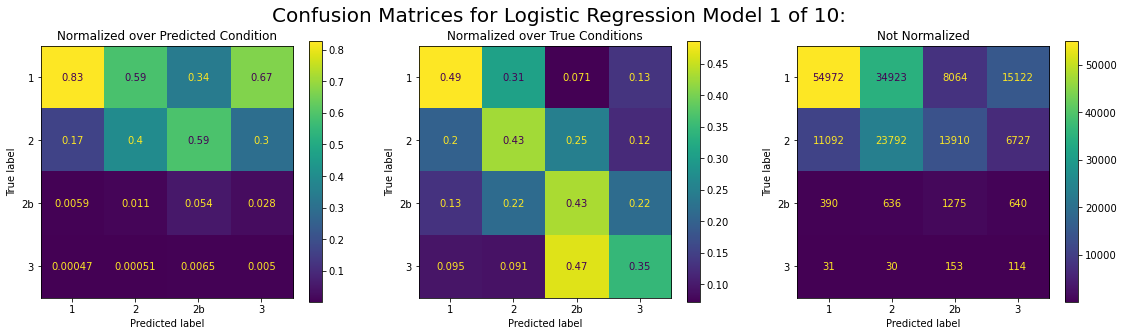

Logistic Regression Model 2 of 10:

              precision    recall  f1-score   support

           1   0.839457  0.452967  0.588424    113081
           2   0.392685  0.449019  0.418967     55521
          2b   0.052270  0.406324  0.092625      2941
           3   0.004570  0.341463  0.009020       328

    accuracy                       0.450681    171871
   macro avg   0.322246  0.412444  0.277259    171871
weighted avg   0.680069  0.450681  0.524093    171871



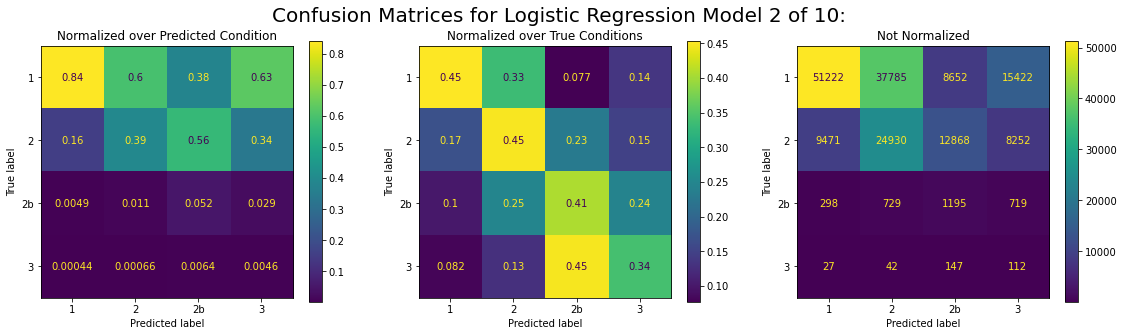

Logistic Regression Model 3 of 10:

              precision    recall  f1-score   support

           1   0.838760  0.458088  0.592553    113081
           2   0.397973  0.407305  0.402585     55521
          2b   0.046319  0.437946  0.083778      2941
           3   0.004827  0.375000  0.009531       328

    accuracy                       0.441180    171871
   macro avg   0.321970  0.419585  0.272112    171871
weighted avg   0.681217  0.441180  0.521367    171871



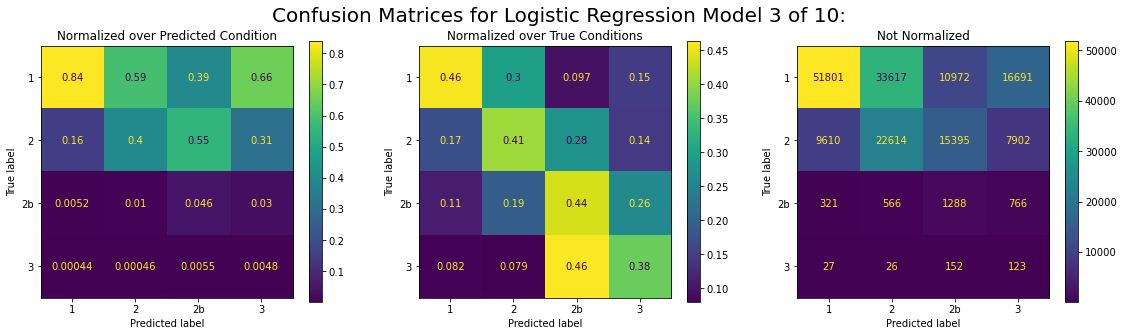

Logistic Regression Model 4 of 10:

              precision    recall  f1-score   support

           1   0.853886  0.462686  0.600166    113081
           2   0.402172  0.452892  0.426028     55521
          2b   0.047950  0.394424  0.085505      2941
           3   0.006155  0.448171  0.012144       328

    accuracy                       0.458326    171871
   macro avg   0.327541  0.439543  0.280961    171871
weighted avg   0.692556  0.458326  0.533984    171871



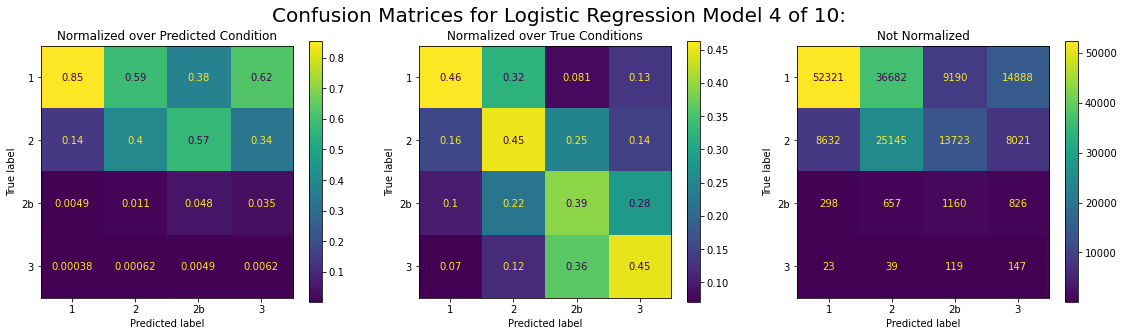

Logistic Regression Model 5 of 10:

              precision    recall  f1-score   support

           1   0.839397  0.464782  0.598287    113081
           2   0.389554  0.446119  0.415922     55521
          2b   0.048488  0.431146  0.087172      2941
           3   0.005890  0.350610  0.011586       328

    accuracy                       0.457960    171871
   macro avg   0.320832  0.423164  0.278242    171871
weighted avg   0.678956  0.457960  0.529510    171871



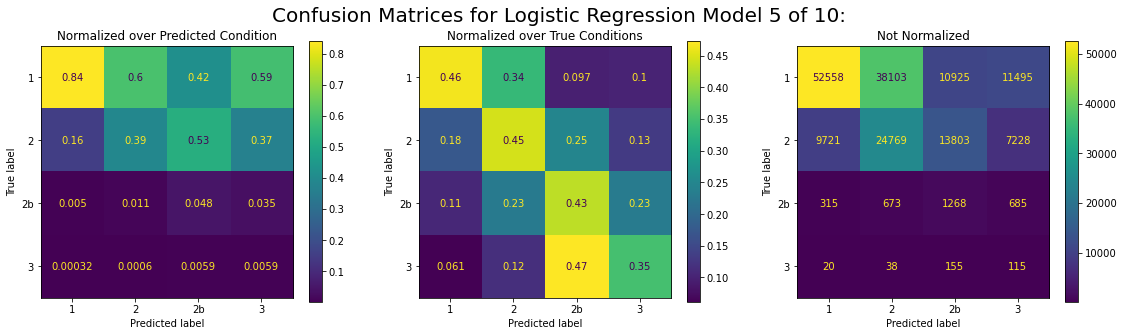

Logistic Regression Model 6 of 10:

              precision    recall  f1-score   support

           1   0.835055  0.478277  0.608205    113081
           2   0.400973  0.446768  0.422634     55521
          2b   0.056163  0.396464  0.098388      2941
           3   0.004983  0.371951  0.009835       328

    accuracy                       0.466495    171871
   macro avg   0.324294  0.423365  0.284765    171871
weighted avg   0.679917  0.466495  0.538392    171871



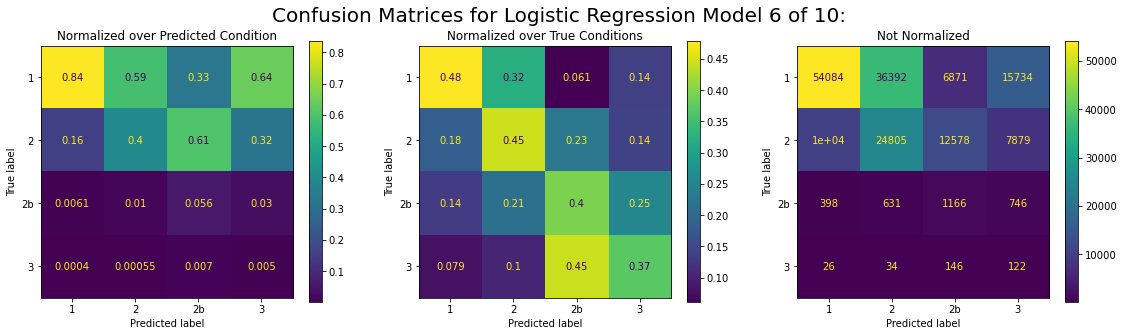

Logistic Regression Model 7 of 10:

              precision    recall  f1-score   support

           1   0.837048  0.467293  0.599762    113081
           2   0.404044  0.452387  0.426851     55521
          2b   0.054002  0.402584  0.095230      2941
           3   0.005070  0.381098  0.010008       328

    accuracy                       0.461206    171871
   macro avg   0.325041  0.425841  0.282963    171871
weighted avg   0.682184  0.461206  0.534146    171871



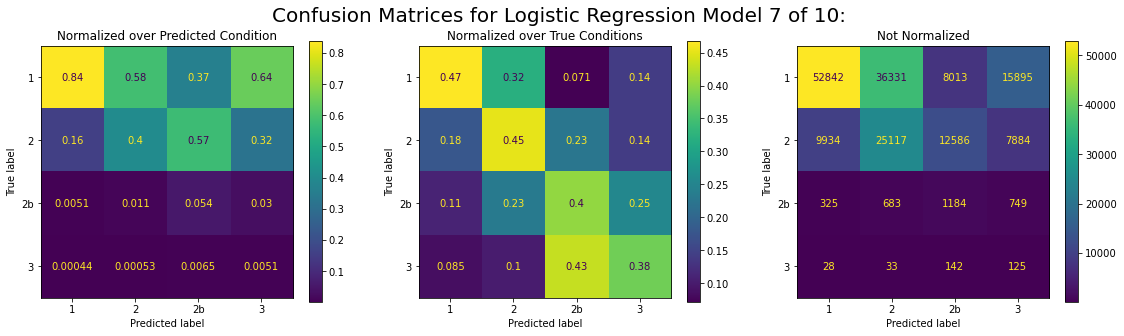

Logistic Regression Model 8 of 10:

              precision    recall  f1-score   support

           1   0.841950  0.484608  0.615150    113081
           2   0.397479  0.441256  0.418225     55521
          2b   0.058013  0.419245  0.101922      2941
           3   0.005064  0.368902  0.009991       328

    accuracy                       0.469265    171871
   macro avg   0.325626  0.428503  0.286322    171871
weighted avg   0.683357  0.469265  0.541598    171871



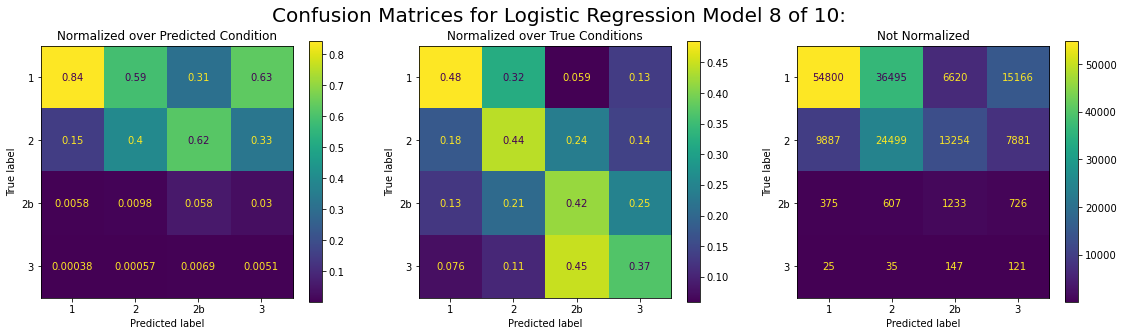

Logistic Regression Model 9 of 10:

              precision    recall  f1-score   support

           1   0.852159  0.459414  0.596984    113081
           2   0.406012  0.440068  0.422355     55521
          2b   0.045135  0.438626  0.081848      2941
           3   0.005328  0.359756  0.010500       328

    accuracy                       0.452619    171871
   macro avg   0.327158  0.424466  0.277921    171871
weighted avg   0.692610  0.452619  0.530638    171871



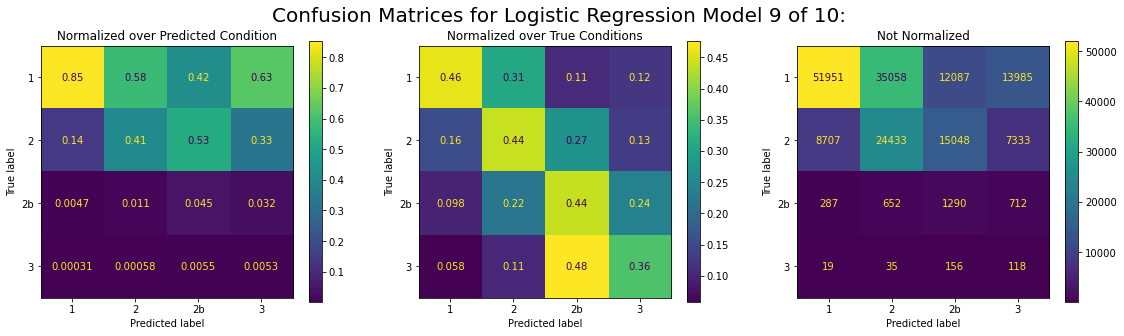

Logistic Regression Model 10 of 10:

              precision    recall  f1-score   support

           1   0.834498  0.472157  0.603088    113081
           2   0.391513  0.439527  0.414133     55521
          2b   0.048471  0.379463  0.085962      2941
           3   0.006390  0.439024  0.012596       328

    accuracy                       0.459967    171871
   macro avg   0.320218  0.432543  0.278945    171871
weighted avg   0.676366  0.459967  0.532073    171871



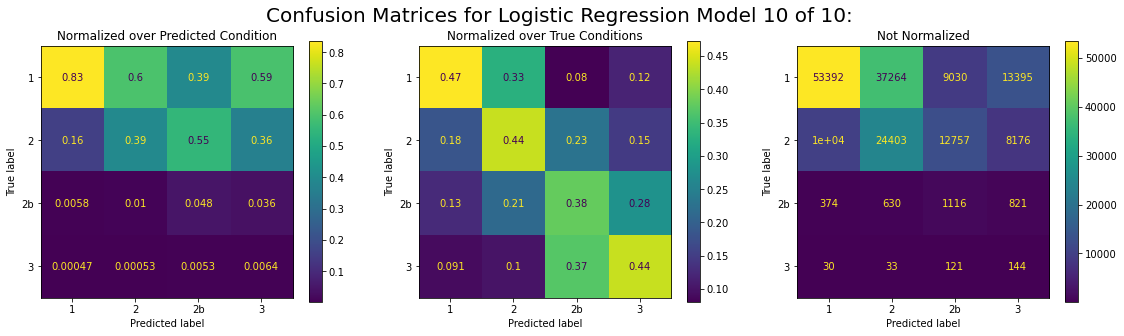

In [66]:
# For each logistic regression classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(logistic_regression_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, logistic_regression_clf in zip(range(len(logistic_regression_scores['estimator'])), logistic_regression_scores['estimator']):
    y_test_predicted = logistic_regression_clf.predict(X_test)
    logistic_regression_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Logistic Regression Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Logistic Regression Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(logistic_regression_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [67]:
print_elapsed_time(notebook_start_time)

Elapsed time is 374.4321593979839 seconds.


In [68]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(linear_svc_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(linear_svc_scores[key]), np.std(linear_svc_scores[key])), sep='')
        print('%s :%s' % (key, linear_svc_scores[key]), sep='')
        print()

fit_time: mean = 0.035901, std = 0.008878
fit_time :[0.03841448 0.03849149 0.04812694 0.05184078 0.03270483 0.02451539
 0.03577614 0.03838682 0.02396345 0.02678585]

score_time: mean = 0.031371, std = 0.004144
score_time :[0.0331862  0.02829838 0.02859926 0.03324127 0.02694035 0.02624464
 0.03307962 0.03983545 0.02852917 0.0357573 ]

test_f1_macro: mean = 0.429468, std = 0.061836
test_f1_macro :[0.53869048 0.39289216 0.42311508 0.37974797 0.43014706 0.41336314
 0.51049837 0.36342167 0.49603175 0.3467699 ]

test_f1_weighted: mean = 0.429126, std = 0.063274
test_f1_weighted :[0.53968254 0.39310755 0.42328042 0.38405073 0.42468806 0.41016099
 0.51641909 0.35707089 0.49603175 0.3467699 ]

test_precision_macro: mean = 0.447449, std = 0.060152
test_precision_macro :[0.575      0.40138889 0.44375    0.40297619 0.43611111 0.43238636
 0.51517857 0.38555195 0.5        0.38214286]

test_precision_weighted: mean = 0.449030, std = 0.062612
test_precision_weighted :[0.58181818 0.4043771  0.44848485 

Support Vector Machine Model 1 of 10:

              precision    recall  f1-score   support

           1   0.828656  0.485112  0.611967    113081
           2   0.400106  0.434070  0.416397     55521
          2b   0.058247  0.418565  0.102264      2941
           3   0.004855  0.359756  0.009581       328

    accuracy                       0.467246    171871
   macro avg   0.322966  0.424376  0.285052    171871
weighted avg   0.675462  0.467246  0.538919    171871



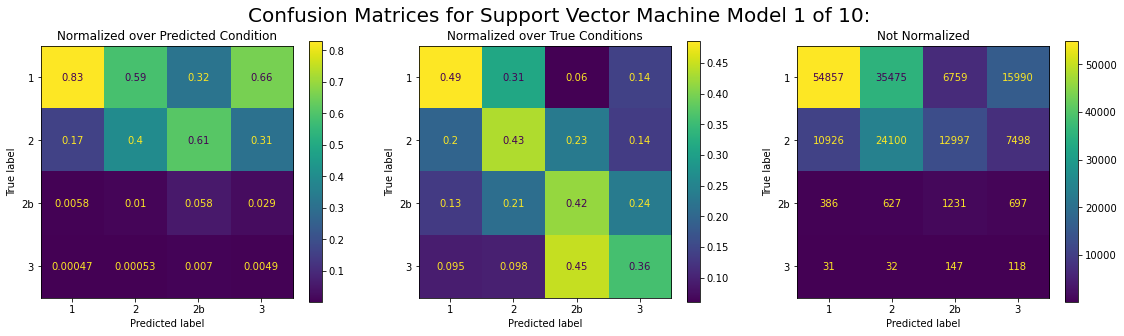

Support Vector Machine Model 2 of 10:

              precision    recall  f1-score   support

           1   0.842644  0.450969  0.587512    113081
           2   0.389216  0.469210  0.425486     55521
          2b   0.059050  0.396124  0.102779      2941
           3   0.004536  0.341463  0.008953       328

    accuracy                       0.455714    171871
   macro avg   0.323862  0.414441  0.281182    171871
weighted avg   0.681161  0.455714  0.525772    171871



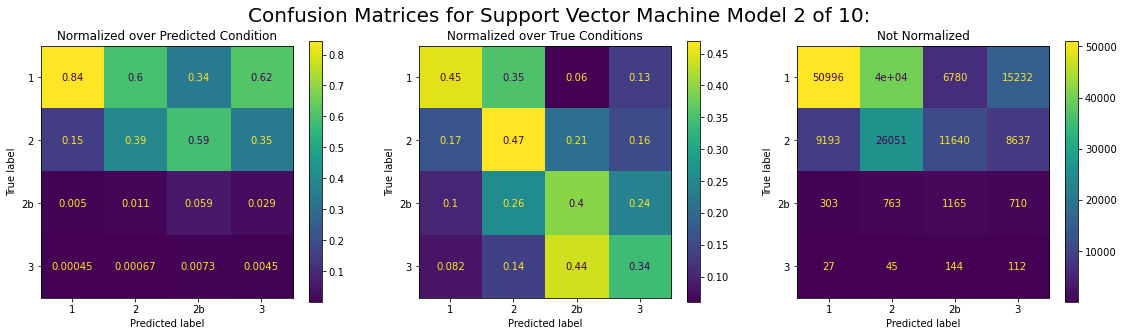

Support Vector Machine Model 3 of 10:

              precision    recall  f1-score   support

           1   0.849876  0.455974  0.593516    113081
           2   0.398205  0.428234  0.412674     55521
          2b   0.046265  0.448147  0.083872      2941
           3   0.005173  0.362805  0.010200       328

    accuracy                       0.446701    171871
   macro avg   0.324880  0.423790  0.275065    171871
weighted avg   0.688606  0.446701  0.525263    171871



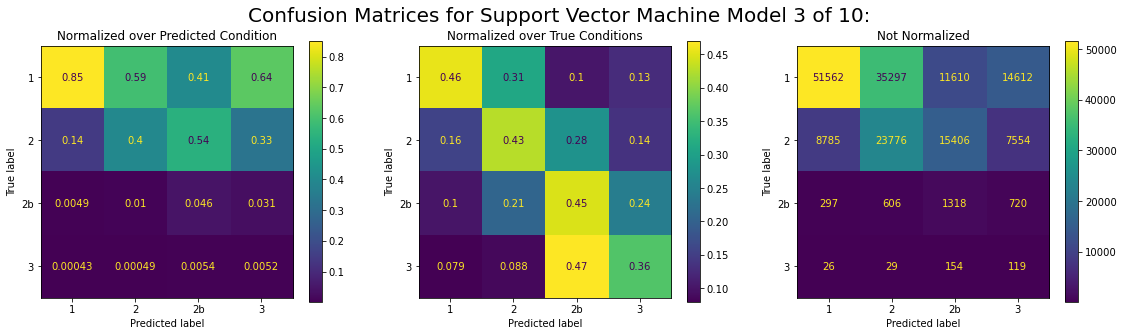

Support Vector Machine Model 4 of 10:

              precision    recall  f1-score   support

           1   0.864902  0.443178  0.586058    113081
           2   0.401348  0.476108  0.435543     55521
          2b   0.047776  0.394424  0.085228      2941
           3   0.006180  0.448171  0.012193       328

    accuracy                       0.452991    171871
   macro avg   0.330052  0.440470  0.279756    171871
weighted avg   0.699535  0.452991  0.527771    171871



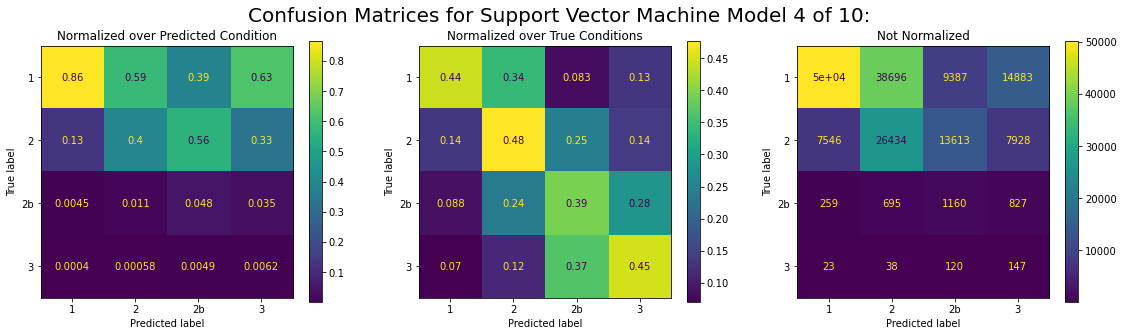

Support Vector Machine Model 5 of 10:

              precision    recall  f1-score   support

           1   0.842175  0.466789  0.600655    113081
           2   0.389075  0.450784  0.417662     55521
          2b   0.049519  0.436246  0.088943      2941
           3   0.005802  0.335366  0.011407       328

    accuracy                       0.460846    171871
   macro avg   0.321643  0.422296  0.279667    171871
weighted avg   0.680646  0.460846  0.531661    171871



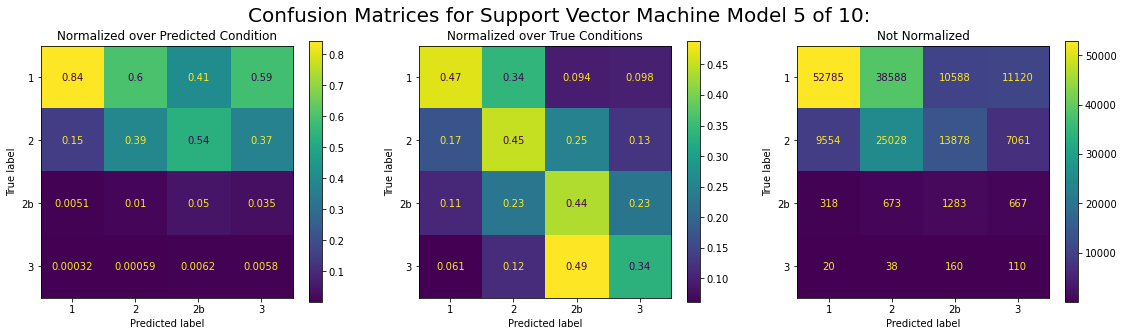

Support Vector Machine Model 6 of 10:

              precision    recall  f1-score   support

           1   0.844451  0.462801  0.597915    113081
           2   0.399448  0.466796  0.430504     55521
          2b   0.058337  0.405644  0.102005      2941
           3   0.004885  0.365854  0.009641       328

    accuracy                       0.462929    171871
   macro avg   0.326780  0.425274  0.285016    171871
weighted avg   0.685644  0.462929  0.534226    171871



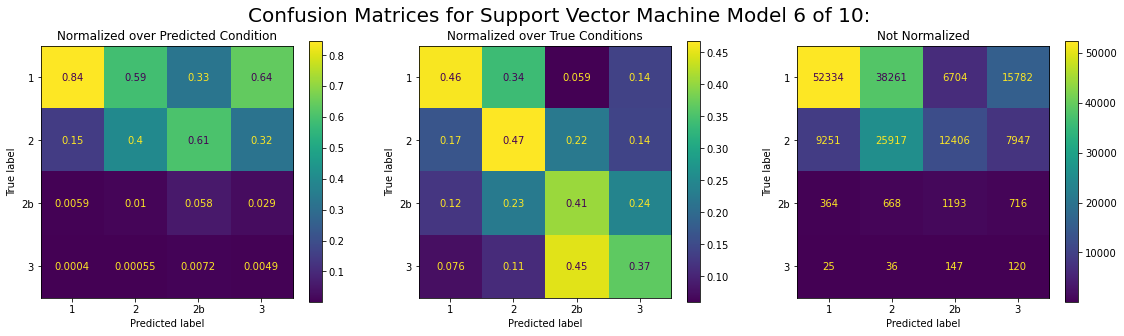

Support Vector Machine Model 7 of 10:

              precision    recall  f1-score   support

           1   0.839388  0.468726  0.601542    113081
           2   0.402365  0.458421  0.428568     55521
          2b   0.055805  0.405304  0.098103      2941
           3   0.005102  0.375000  0.010067       328

    accuracy                       0.464133    171871
   macro avg   0.325665  0.426863  0.284570    171871
weighted avg   0.683212  0.464133  0.535921    171871



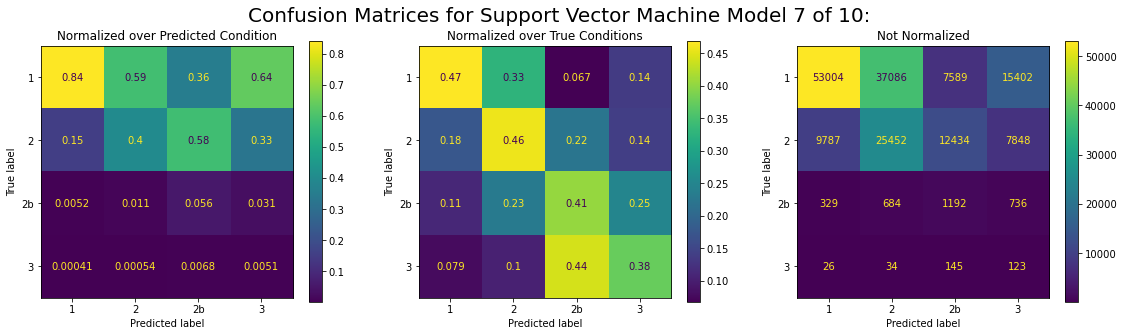

Support Vector Machine Model 8 of 10:

              precision    recall  f1-score   support

           1   0.848820  0.471290  0.606072    113081
           2   0.395954  0.468904  0.429352     55521
          2b   0.063598  0.422305  0.110547      2941
           3   0.004831  0.350610  0.009530       328

    accuracy                       0.469451    171871
   macro avg   0.328301  0.428277  0.288875    171871
weighted avg   0.687480  0.469451  0.539367    171871



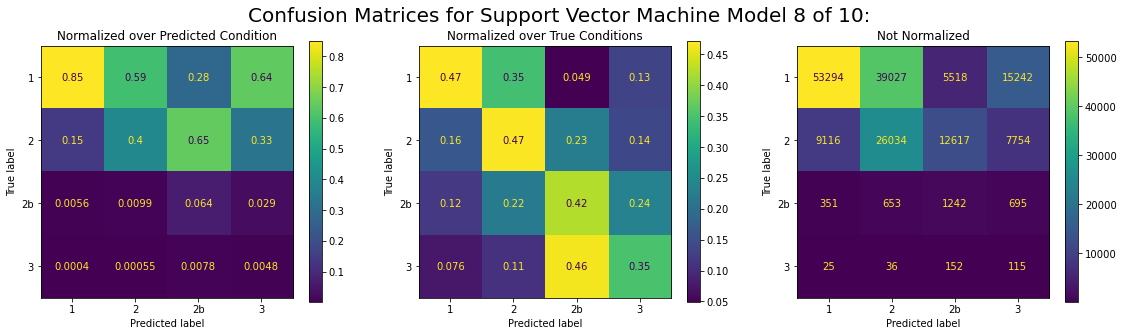

Support Vector Machine Model 9 of 10:

              precision    recall  f1-score   support

           1   0.859615  0.445486  0.586846    113081
           2   0.401112  0.452333  0.425185     55521
          2b   0.047582  0.456307  0.086178      2941
           3   0.004988  0.341463  0.009833       328

    accuracy                       0.447685    171871
   macro avg   0.328324  0.423898  0.277010    171871
weighted avg   0.695974  0.447685  0.524955    171871



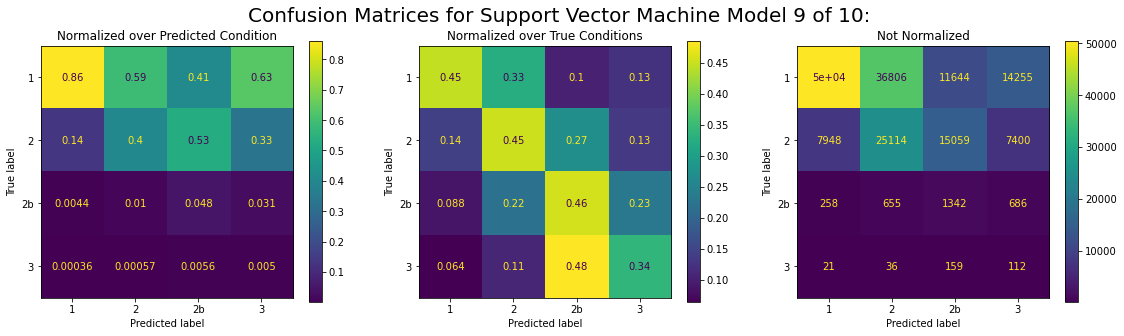

Support Vector Machine Model 10 of 10:

              precision    recall  f1-score   support

           1   0.856824  0.441206  0.582476    113081
           2   0.389921  0.450964  0.418227     55521
          2b   0.044527  0.400544  0.080144      2941
           3   0.006312  0.442073  0.012446       328

    accuracy                       0.443664    171871
   macro avg   0.324396  0.433697  0.273323    171871
weighted avg   0.690473  0.443664  0.519734    171871



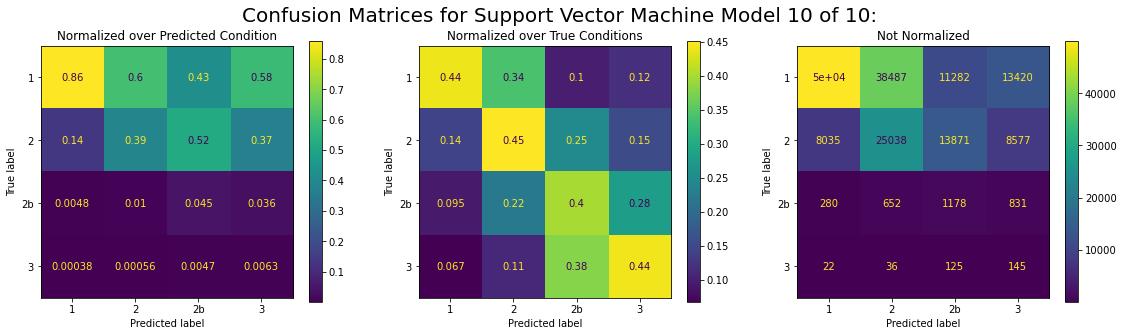

In [69]:
# For each support vector machine classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(linear_svc_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, linear_svc_clf in zip(range(len(linear_svc_scores['estimator'])), linear_svc_scores['estimator']):
    y_test_predicted = linear_svc_clf.predict(X_test)
    linear_svc_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('Support Vector Machine Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for Support Vector Machine Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1,3,1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1,3,2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1,3,3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(linear_svc_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)
    
    plt.show()

In [70]:
# Report statistics of the models built for each fold of the cross-validation.
for key in sorted(k_neighbors_scores.keys()):
    if key != 'estimator':
        print('%s: mean = %f, std = %f' % (key, np.mean(k_neighbors_scores[key]), np.std(k_neighbors_scores[key])), sep='')
        print('%s :%s' % (key, k_neighbors_scores[key]), sep='')
        print()

fit_time: mean = 0.018551, std = 0.008236
fit_time :[0.01689386 0.04113436 0.02334404 0.01537228 0.01544404 0.01361442
 0.01717114 0.01074624 0.01916814 0.0126183 ]

score_time: mean = 0.106353, std = 0.018820
score_time :[0.14573359 0.12146568 0.11400247 0.10928488 0.08502102 0.08900023
 0.09322357 0.118608   0.10565782 0.08152819]

test_f1_macro: mean = 0.378332, std = 0.067673
test_f1_macro :[0.44444444 0.28214922 0.44112554 0.33966269 0.23966165 0.41481782
 0.44112554 0.40820232 0.36136364 0.41076277]

test_f1_weighted: mean = 0.377462, std = 0.067521
test_f1_weighted :[0.43905724 0.28072937 0.43987931 0.34391534 0.23744968 0.41326687
 0.44428703 0.40391336 0.36136364 0.41076277]

test_neg_log_loss: mean = -7.485535, std = 2.495979
test_neg_log_loss :[ -9.05944378 -11.26759878  -6.17798928  -6.18150181 -12.32483133
  -7.02190435  -5.07793101  -4.12176836  -6.33526523  -7.2871133 ]

test_precision_macro: mean = 0.410364, std = 0.080870
test_precision_macro :[0.44047619 0.29754274 0.

k-Nearest Neighbor Model 1 of 10:

              precision    recall  f1-score   support

           1   0.793868  0.498943  0.612766    113081
           2   0.390018  0.436718  0.412049     55521
          2b   0.066071  0.344441  0.110874      2941
           3   0.004764  0.338415  0.009396       328

    accuracy                       0.475892    171871
   macro avg   0.313680  0.404629  0.286271    171871
weighted avg   0.649449  0.475892  0.538187    171871



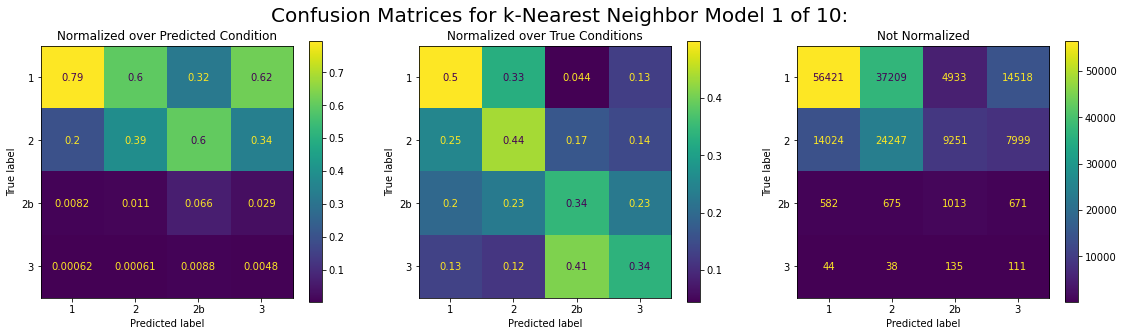

k-Nearest Neighbor Model 2 of 10:

              precision    recall  f1-score   support

           1   0.792635  0.517514  0.626188    113081
           2   0.395059  0.418760  0.406564     55521
          2b   0.055012  0.407344  0.096933      2941
           3   0.005284  0.280488  0.010373       328

    accuracy                       0.483275    171871
   macro avg   0.311997  0.406027  0.285015    171871
weighted avg   0.650078  0.483275  0.545009    171871



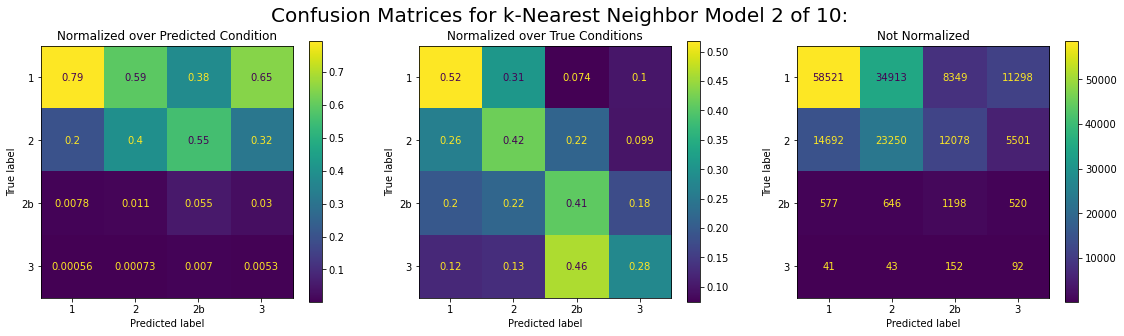

k-Nearest Neighbor Model 3 of 10:

              precision    recall  f1-score   support

           1   0.815559  0.475296  0.600582    113081
           2   0.394505  0.473533  0.430421     55521
          2b   0.058930  0.429786  0.103649      2941
           3   0.004811  0.262195  0.009448       328

    accuracy                       0.473541    171871
   macro avg   0.318451  0.410202  0.286025    171871
weighted avg   0.665048  0.473541  0.535982    171871



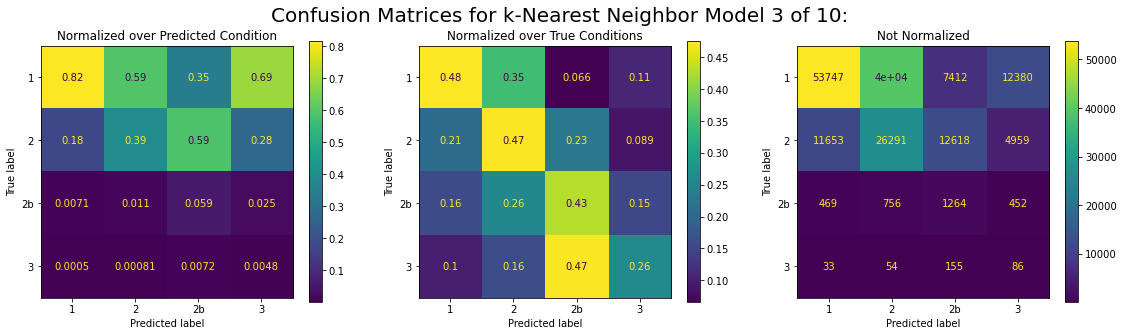

k-Nearest Neighbor Model 4 of 10:

              precision    recall  f1-score   support

           1   0.812879  0.446742  0.576597    113081
           2   0.383747  0.483187  0.427764     55521
          2b   0.059788  0.370622  0.102966      2941
           3   0.005930  0.390244  0.011683       328

    accuracy                       0.457104    171871
   macro avg   0.315586  0.422699  0.279753    171871
weighted avg   0.659826  0.457104  0.519336    171871



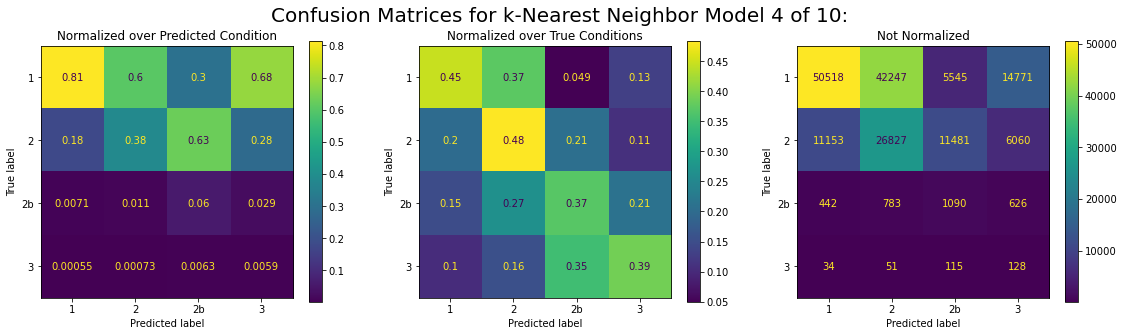

k-Nearest Neighbor Model 5 of 10:

              precision    recall  f1-score   support

           1   0.791847  0.523890  0.630583    113081
           2   0.400037  0.430053  0.414502     55521
          2b   0.057142  0.412445  0.100377      2941
           3   0.007001  0.344512  0.013723       328

    accuracy                       0.491328    171871
   macro avg   0.314006  0.427725  0.289796    171871
weighted avg   0.651207  0.491328  0.550531    171871



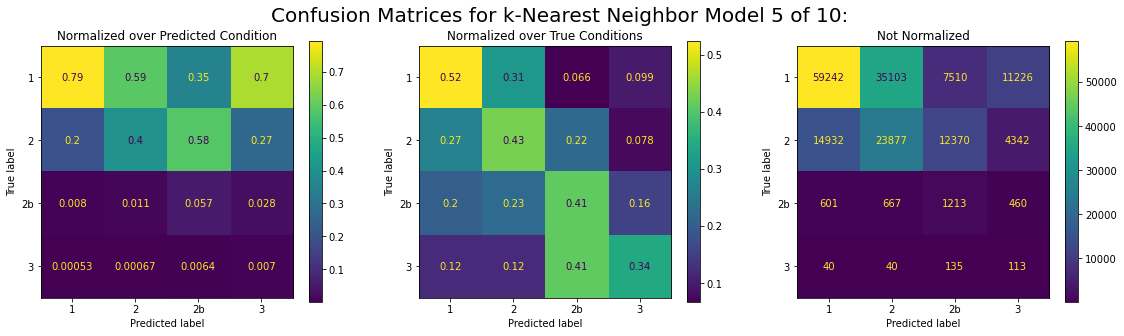

k-Nearest Neighbor Model 6 of 10:

              precision    recall  f1-score   support

           1   0.803088  0.502295  0.618036    113081
           2   0.402513  0.444300  0.422376     55521
          2b   0.058527  0.453587  0.103676      2941
           3   0.004981  0.259146  0.009773       328

    accuracy                       0.482263    171871
   macro avg   0.317277  0.414832  0.288465    171871
weighted avg   0.659423  0.482263  0.544868    171871



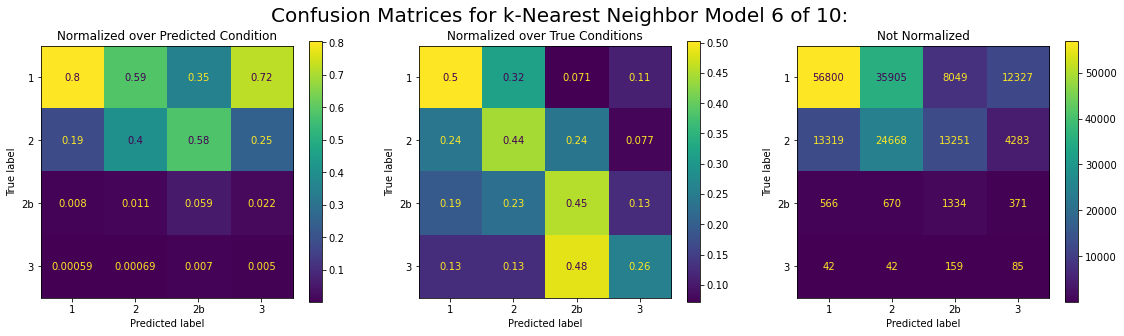

k-Nearest Neighbor Model 7 of 10:

              precision    recall  f1-score   support

           1   0.790156  0.529682  0.634217    113081
           2   0.402554  0.452604  0.426114     55521
          2b   0.069192  0.353961  0.115757      2941
           3   0.005001  0.283537  0.009828       328

    accuracy                       0.501306    171871
   macro avg   0.316726  0.404946  0.296479    171871
weighted avg   0.651110  0.501306  0.556928    171871



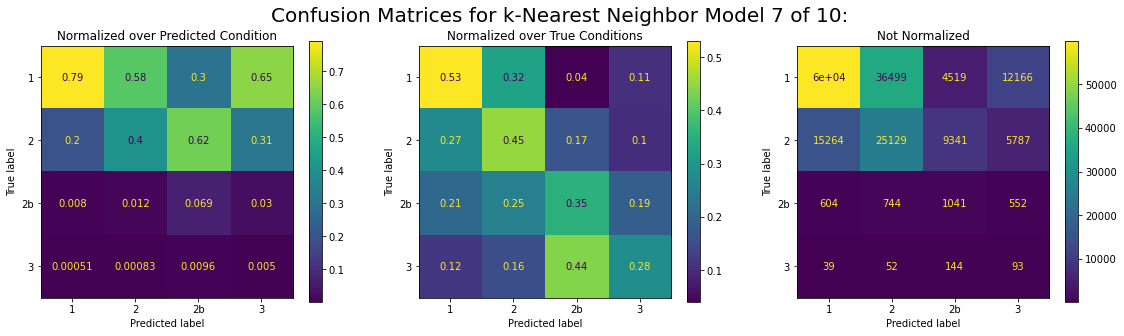

k-Nearest Neighbor Model 8 of 10:

              precision    recall  f1-score   support

           1   0.834739  0.482097  0.611200    113081
           2   0.389053  0.498136  0.436888     55521
          2b   0.058917  0.468208  0.104663      2941
           3   0.006858  0.253049  0.013355       328

    accuracy                       0.486603    171871
   macro avg   0.322392  0.425372  0.291527    171871
weighted avg   0.675910  0.486603  0.545082    171871



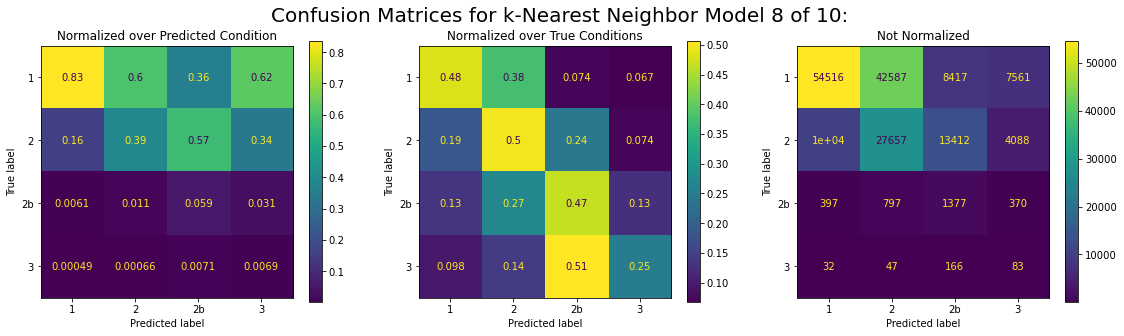

k-Nearest Neighbor Model 9 of 10:

              precision    recall  f1-score   support

           1   0.795689  0.503754  0.616928    113081
           2   0.401236  0.433836  0.416900     55521
          2b   0.058927  0.466848  0.104645      2941
           3   0.005075  0.262195  0.009957       328

    accuracy                       0.480075    171871
   macro avg   0.315232  0.416658  0.287107    171871
weighted avg   0.654150  0.480075  0.542387    171871



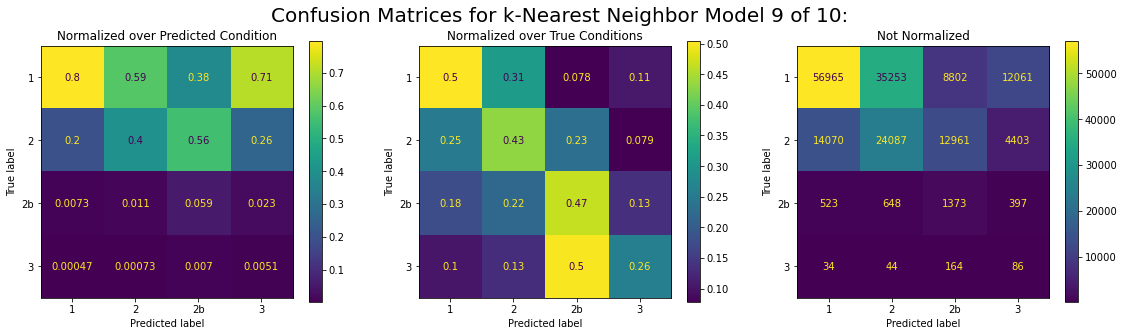

k-Nearest Neighbor Model 10 of 10:

              precision    recall  f1-score   support

           1   0.817405  0.457911  0.586990    113081
           2   0.386529  0.483006  0.429416     55521
          2b   0.053596  0.362122  0.093372      2941
           3   0.006486  0.381098  0.012754       328

    accuracy                       0.464232    171871
   macro avg   0.316004  0.421034  0.280633    171871
weighted avg   0.663598  0.464232  0.526545    171871



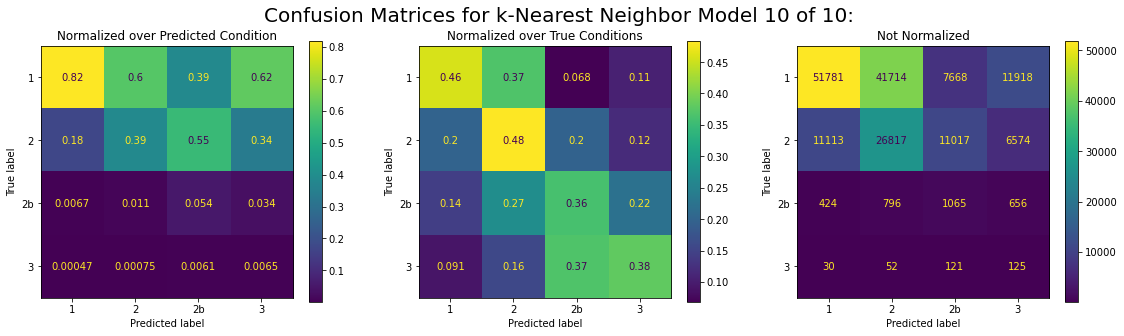

In [71]:
# For each k-Nearest Neighbor classifier in the cross-validation, print the macro recall, score report, and confusion matrices.
number_of_models = len(k_neighbors_scores['estimator'])
labels = ['1', '2', '2b', '3']
for index, knn_clf in zip(range(len(k_neighbors_scores['estimator'])), k_neighbors_scores['estimator']):
    y_test_predicted = knn_clf.predict(X_test)
    knn_recall_score = recall_score(y_test, y_test_predicted, average='macro', labels=labels)
    print('k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models))
    print()
    print(classification_report(y_test, y_test_predicted, labels=labels, target_names=labels, digits=6))
        
    # Create a figure.
    fig = plt.figure(num=str(index + 1), figsize=(6.4 * 3, 4.8))
    fig.suptitle('Confusion Matrices for k-Nearest Neighbor Model %d of %d:' % (index + 1, number_of_models), fontsize=20)
    
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Normalized over Predicted Condition", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='pred', ax=ax)
    
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Normalized over True Conditions", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize='true', ax=ax)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Not Normalized", fontsize=12)
    plot_confusion_matrix(knn_clf, X_test, y_test, labels=labels, display_labels=labels, normalize=None, ax=ax)

    plt.show()

In [72]:
print('Reports and graphics generated in %f seconds' % (elapsed_time(t0)))

Reports and graphics generated in 1422.430316 seconds


In [73]:
print_elapsed_time(notebook_start_time)

Elapsed time is 1492.8932062159292 seconds.
